In [ ]:
import pandas as pd

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge the customer data with transaction data
merged_data = transactions.merge(customers, on="CustomerID", how="left")

# Check the first few rows of the merged data
print(merged_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


In [ ]:
print(merged_data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')


In [ ]:
# Total spending per customer
customer_spending = merged_data.groupby("CustomerID")["TotalValue"].sum().rename("TotalSpending")

# Purchase frequency
purchase_frequency = merged_data.groupby("CustomerID")["TransactionID"].nunique().rename("PurchaseFrequency")

# Average spending per transaction
avg_spending = (customer_spending / purchase_frequency).rename("AvgSpending")

# Combine all features (excluding 'Category' since it's not available)
customer_features = pd.concat([customer_spending, purchase_frequency, avg_spending], axis=1).reset_index()

# Ensure 'Region' is included in customer_features for one-hot encoding
customer_features = pd.merge(customer_features, merged_data[['CustomerID', 'Region']].drop_duplicates(), on='CustomerID', how='left')

# Handle categorical data (Region) with one-hot encoding
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

# Preview the features
print(customer_features.head())


  CustomerID  TotalSpending  PurchaseFrequency  AvgSpending  Region_Europe  \
0      C0001        3354.52                  5      670.904          False   
1      C0002        1862.74                  4      465.685          False   
2      C0003        2725.38                  4      681.345          False   
3      C0004        5354.88                  8      669.360          False   
4      C0005        2034.24                  3      678.080          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features.drop("CustomerID", axis=1))

# Check the scaled features
print(features_scaled[:5])


[[-0.06170143 -0.01145819 -0.07026341 -0.57928445 -0.54831888  1.54041597]
 [-0.87774353 -0.46749414 -0.93493297 -0.57928445 -0.54831888 -0.6491753 ]
 [-0.40585722 -0.46749414 -0.02627131 -0.57928445 -0.54831888  1.54041597]
 [ 1.03254704  1.35664965 -0.0767689  -0.57928445 -0.54831888  1.54041597]
 [-0.78392861 -0.92353008 -0.04002806 -0.57928445 -0.54831888 -0.6491753 ]]


In [ ]:
from sklearn.cluster import KMeans

# Choose the number of clusters (between 2 and 10)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model
customer_features["Cluster"] = kmeans.fit_predict(features_scaled)

# Check the cluster assignments
print(customer_features[["CustomerID", "Cluster"]].head())


  CustomerID  Cluster
0      C0001        1
1      C0002        3
2      C0003        1
3      C0004        1
4      C0005        3


In [ ]:
from sklearn.metrics import davies_bouldin_score

# Calculate the DB Index for the clustering
db_index = davies_bouldin_score(features_scaled, customer_features["Cluster"])

print(f"DB Index: {db_index}")


DB Index: 1.1236219126170808


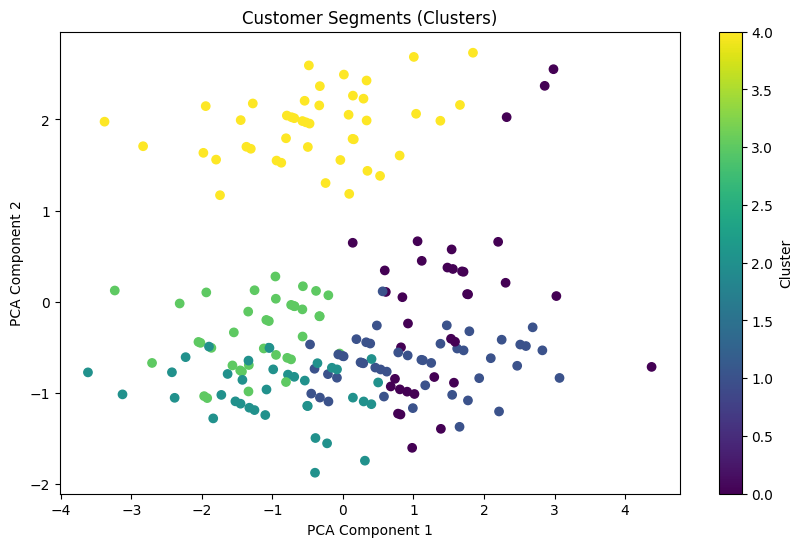

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Add cluster labels to the reduced features
features_2d_df = pd.DataFrame(features_2d, columns=["PCA1", "PCA2"])
features_2d_df["Cluster"] = customer_features["Cluster"]

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_2d_df["PCA1"], features_2d_df["PCA2"], c=features_2d_df["Cluster"], cmap="viridis")
plt.title("Customer Segments (Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
customer_features.to_csv("Customer_Segmentation.csv", index=False)
